# Imports

In [1]:
import pandas as pd
import numpy as np
import zipfile
import os
import matplotlib.pyplot as plt
import tensorflow
from keras.preprocessing.image import load_img,img_to_array
from sklearn.model_selection import train_test_split
from sklearn import neighbors
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
from collections import Counter
from sklearn import svm
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from matplotlib.colors import ListedColormap
import matplotlib.image as mpimg
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
import time
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import LabelEncoder
import keras
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from keras.applications.inception_v3 import InceptionV3, preprocess_input
from keras.models import Sequential
from keras.initializers import TruncatedNormal
from keras.wrappers.scikit_learn import KerasRegressor
from keras.callbacks import ModelCheckpoint
from keras.layers import Dense, Activation, Flatten, Conv1D ,Input,MaxPooling1D, Dropout,AveragePooling1D, BatchNormalization
from keras.layers import Conv2D, MaxPooling2D,AveragePooling2D, GlobalAveragePooling2D
from keras.models import load_model
from keras.models import Model
import keras.losses
from keras.optimizers import SGD
import pickle
from sklearn.utils import shuffle
from sklearn.manifold import TSNE

Using TensorFlow backend.


# Functions

In [2]:
def train_dev_test_split(images, labels):
    #train->0.7, dev->0.15, test->0.15
    frac_train=0.7
    frac_test=0.15
    X_train, X_test, y_train, y_test = train_test_split(images, labels, test_size=frac_test, random_state=78)
    frac_dev=0.15/(frac_train+frac_test)
    X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=frac_dev, random_state=78)
    print("Train Set:",X_train.shape, "| Dev Set:",X_dev.shape, "| Test Set:",X_test.shape )
    return(X_train, X_test, X_dev, y_train, y_test, y_dev)

In [3]:
def feature_selection(images,variance_lower_limit):
    selector = VarianceThreshold(variance_lower_limit)
    images_reduced = selector.fit_transform(images)
    print("Images original shape: ",images.shape)
    print("Images reduced shape: ",images_reduced.shape)
    return images_reduced

In [4]:
#convert raw rgb image to normalized in [0,1] one-hot vectors
def load_reshape_img(img,grayscale):
    x = img_to_array(img)/255.
    if grayscale==True:
        x = rgb2gray(x)   
    x = x.reshape((1,)+x.shape)
    x = x.flatten()
    return x

In [5]:
 #https://pillow.readthedocs.io/en/3.2.x/reference/Image.html#PIL.Image.Image.convert
def rgb2gray(rgb):
    return np.dot(rgb[...,:3], [0.2989, 0.5870, 0.1140])

In [6]:
#convert the dataset with image names features to dataset with flattened one hot encoding vectors of pixels
def create_flattened_dataset(dataset,size,grayscale):
    dataset_copy=dataset.copy()
    for i in dataset:
        img_name=images_folder + i
        img = load_img(img_name, target_size=size)
        img_vector=load_reshape_img(img,grayscale)
        dataset_copy.loc[int(img_name.split('/')[-1].split('.')[0])] = img_vector
    dataset_np=np.stack(dataset_copy)
    dataset_pd = pd.DataFrame(dataset_np)
    return(dataset_pd)

In [7]:
#check for NaN values in one-hot encodings ,e.g. missing pixels
def check_NaN_values(features,_labels):
    _labels=np.array(_labels)
    NaNvaluesData=np.isnan(_labels).sum().sum()
    if NaNvaluesData>0 :
            where_is_NaN = np.isnan(_labels)
            print("NaN value in labels index: ",where_is_NaN)
    else:
        print("No NaN values in Labels.")
    features=np.array(features)
    NaNvaluesData=np.isnan(features).sum().sum()
    if NaNvaluesData>0 :
        where_is_NaN = np.isnan(features)
        print("Number of NaN values in augmented image: ",where_is_NaN)
    else:
        print("No NaN values in Reshaped Images.")    
    return

In [8]:
def Print_Classification_Results(y_dev,y_pred):
    print(classification_report(y_dev, y_pred))
    acc_score = accuracy_score(y_dev, y_pred)
    print("\nAccuracy Score: ","{:.3%}".format(acc_score))
    conf_matrix = confusion_matrix(y_dev, y_pred)
    labels=['0','1','2','3','4']
    sns.heatmap(conf_matrix, annot=True, fmt='g', xticklabels=labels, yticklabels=labels,cmap= "BuPu")
    plt.show() 
    return acc_score

In [9]:
def plot_images_true_predicted_faceShape(labels,predictions,images_folder):
    fig = plt.gcf()
    fig.set_size_inches(16,20)
    for i in range(21):
        ax = plt.subplot(5,7,1+i)
        img_id = labels.index.values[i].astype(int)
        img_id = images_folder + str(img_id)+'.png'
        img = load_img(img_id)
        ax.imshow(img, cmap='binary')
        title ="Label=" + str(labels.iloc[i]) + ",Prediction= " +str(predictions[i]) 
        ax.set_title(title,fontsize=10)
    plt.show()
    return

# Read Data

In [10]:
images_folder = '../Datasets/cartoon_set/img/'
dataset = pd.read_csv('../Datasets/cartoon_set/labels.csv', sep = '\t', usecols = [2,3])
print("Dataset Size: ",dataset.shape)
dataset.head()

Dataset Size:  (10000, 2)


,face_shape,file_name
0,4,0.png
1,4,1.png
2,3,2.png
3,0,3.png
4,2,4.png


In [11]:
images = dataset.iloc[:,1]
labels = dataset.iloc[:,0]

**Example of cartoons in Cartoon dataset:**

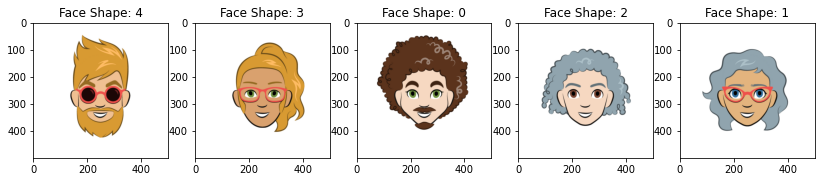

In [12]:
images_folder = '../Datasets/cartoon_set/img/'
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(1, 5, figsize=(14, 3))

EXAMPLE_PIC = images_folder + '0.png'
ax1.set_title("Face Shape: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['face_shape']))
img = load_img(EXAMPLE_PIC)
ax1.imshow(img)

EXAMPLE_PIC = images_folder + '2.png'
ax2.set_title("Face Shape: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['face_shape']))
img = load_img(EXAMPLE_PIC)
ax2.imshow(img)

EXAMPLE_PIC = images_folder + '3.png'
ax3.set_title("Face Shape: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['face_shape']))
img = load_img(EXAMPLE_PIC)
ax3.imshow(img)

EXAMPLE_PIC = images_folder + '4.png'
ax4.set_title("Face Shape: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['face_shape']))
img = load_img(EXAMPLE_PIC)
ax4.imshow(img)

EXAMPLE_PIC = images_folder + '8.png'
ax5.set_title("Face Shape: " + str(dataset.loc[int(EXAMPLE_PIC.split('/')[-1].split('.')[0])]['face_shape']))
img = load_img(EXAMPLE_PIC)
ax5.imshow(img)

## Elaborate on multiclass labels

Class=4, n=2000 (20.000%)
Class=3, n=2000 (20.000%)
Class=0, n=2000 (20.000%)
Class=2, n=2000 (20.000%)
Class=1, n=2000 (20.000%)


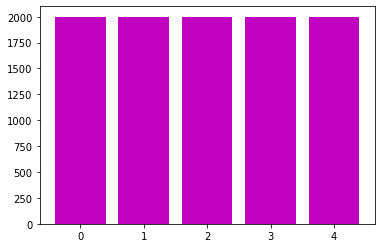

In [40]:
# summarize distribution
counter = Counter(labels)
for k,v in counter.items():
    per = v / len(labels) * 100
    print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
plt.bar(counter.keys(), counter.values(),color='m')
plt.show()

**Balanced Dataset!!**

## Convert cartoon images dataframe to reshaped flattened array images dataframe

* As long as we are interested in cartoon's face shape, which don't need high resolution (since they are cartoons, not human faces), we reduce image shape from (IMG_HEIGHT,IMG_WIDTH)=(500,500) to 110 each and transform images to gray scale.

* We apply these transformatons from the beginning since we have quite a big dataset with high dimensional features that our computational resources cannot handle in their raw format.

Example of how images will be converted:

Step 1 image size: (500, 500, 3)
Step 2 image size: (110, 110, 3)
Step 3 image size: (110, 110, 1)


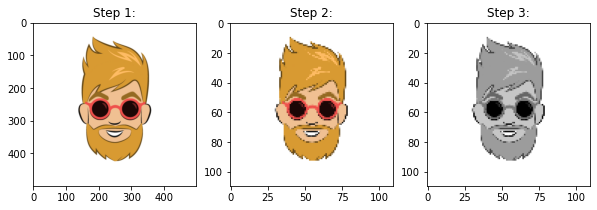

In [41]:
EXAMPLE_PIC = images_folder + '0.png'

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 3))

#original image size = (500,500,3)
img_original = load_img(EXAMPLE_PIC,target_size=(500,500))
ax1.imshow(img_original)
ax1.set_title("Step 1:")
print("Step 1 image size:",img_to_array(img_original).shape)

#reduced image size = (110,110,3)
img = load_img(EXAMPLE_PIC,target_size=(110,110))
ax2.imshow(img)
ax2.set_title("Step 2:")
print("Step 2 image size:",img_to_array(img).shape)

#gray image size = (110,110,1)
arr = img_to_array(img)
gray = rgb2gray(arr)   
ax3.imshow(gray, cmap=plt.get_cmap('gray'))
ax3.set_title("Step 3:")
print("Step 3 image size:",img_to_array(gray).shape)

plt.show()

In [13]:
size=(110,110) 
grayscale=True
reshaped_images=create_flattened_dataset(images,size,grayscale)
check_NaN_values(reshaped_images,labels)

No NaN values in Labels.
No NaN values in Reshaped Images.


## Remove features with zero information (white pixels of background)

### Feature Selection:
If the variance is low or close to zero, then a feature is approximately constant and will not improve the performance of the model. In that case, it should be removed. 
In this problem, these constant fetures are the white pixels of background.

In [15]:
variance_lower_limit=0
reshaped_images_reduced=feature_selection(reshaped_images,variance_lower_limit)

Images original shape:  (10000, 12100)
Images reduced shape:  (10000, 6725)


## Split reshaped dataset into train, dev, test sets

In [16]:
X_train, X_test, X_dev, y_train, y_test, y_dev=train_dev_test_split(reshaped_images_reduced, labels)

Train Set: (7000, 6725) | Dev Set: (1500, 6725) | Test Set: (1500, 6725)


# Baseline Multiclass Classifiers

## Linear SVM

Linear SVM implements “one-vs-one” multi-class strategy, thus training n_classes(=5) models.

Total runtime:  70.64186596870422 s
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       285
           1       1.00      1.00      1.00       308
           2       1.00      1.00      1.00       297
           3       1.00      1.00      1.00       282
           4       1.00      1.00      1.00       328

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  100.000%


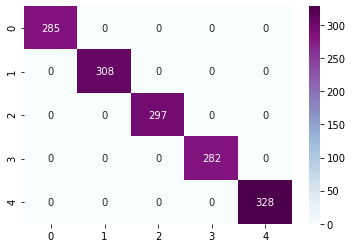

In [17]:
kernel='linear'
gamma='auto'
C=1.0 #default
clf_svm_linear = SVC(kernel=kernel,gamma=gamma, C=C)
start_time = time.time()
clf_svm_linear.fit(X_train, y_train)
y_pred = clf_svm_linear.predict(X_dev)
runtime_Linear_SVM = time.time()-start_time
print("Total runtime: ",runtime_Linear_SVM,"s")
accuracy = Print_Classification_Results(y_dev,y_pred)

### Evaluate the previous model on test data

Total runtime:  74.88504600524902 s
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       307
           1       1.00      1.00      1.00       319
           2       1.00      1.00      1.00       307
           3       1.00      1.00      1.00       295
           4       1.00      1.00      1.00       272

    accuracy                           1.00      1500
   macro avg       1.00      1.00      1.00      1500
weighted avg       1.00      1.00      1.00      1500


Accuracy Score:  100.000%


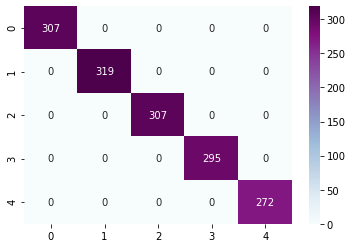

In [16]:
y_pred = clf_svm_linear.predict(X_test)
runtime_Linear_SVM = time.time()-start_time
print("Total runtime: ",runtime_Linear_SVM,"s")
accuracy = Print_Classification_Results(y_test,y_pred)

### Evaluate the previous model on new test data

Dataset Test Size:  (2500, 2)
No NaN values in Labels.
No NaN values in Reshaped Images.
Images original shape:  (2500, 12100)
Images reduced shape:  (2500, 6725)
Total runtime:  194.22692108154297 s
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       500
           1       1.00      1.00      1.00       500
           2       1.00      1.00      1.00       500
           3       1.00      1.00      1.00       500
           4       1.00      1.00      1.00       500

    accuracy                           1.00      2500
   macro avg       1.00      1.00      1.00      2500
weighted avg       1.00      1.00      1.00      2500


Accuracy Score:  99.920%


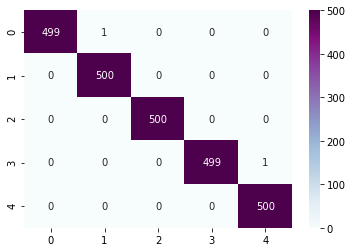

In [20]:
images_folder = '../Datasets/dataset_AMLS_20-21_test/cartoon_set_test/img/'
dataset_test = pd.read_csv('../Datasets/dataset_AMLS_20-21_test/cartoon_set_test/labels.csv', sep = '\t', usecols = [2,3])
print("Dataset Test Size: ",dataset_test.shape)
images_test = dataset_test.iloc[:,1]
labels_test = dataset_test.iloc[:,0]

size=(110,110) 
grayscale=True
reshaped_images_test=create_flattened_dataset(images_test,size,grayscale)
check_NaN_values(reshaped_images_test,labels_test)
variance_lower_limit=0
X_test=feature_selection(reshaped_images_test,variance_lower_limit)
y_test = labels_test

y_pred = clf_svm_linear.predict(X_test)
runtime_Linear_SVM = time.time()-start_time
print("Total runtime: ",runtime_Linear_SVM,"s")
accuracy = Print_Classification_Results(y_test,y_pred)

**By running just a simple linear classification estimator, it is obvious that our data are perfectly linearly separable so we get 100% accuracy in classifying data.**

### Why SVM?

Paper: https://arxiv.org/ftp/arxiv/papers/0709/0709.3967.pdf

Support Vector Machines (SVMs) have their roots in Statistical Learning Theory (Vapnik, 1995).They have been widely applied to machine vision fields such as character, handwriting digit and text recognition (Vapnik, 1995. SVMs, like Artificial Neural Networks and other nonparametric classifiers have a reputation for being robust (Foody and Mathur, 2004a; Foody and Mathur, 2004b).

SVM is an exciting algorithm and the concepts are relatively simple. The classifier separates data points using a hyperplane with the largest amount of margin. That's why an SVM classifier is also known as a discriminative classifier. SVM finds an optimal hyperplane which helps in classifying new data points.

In order to absorb the resulting high dimensionality of the input space, support vector machines (SVMs), which are known to work well even in high-dimensional space, are used as the face recognizer.

# Final Assumptions

Taking into account the perfectly separable unseen dev and test samples into face shape classes we can make the following assumptions about our total dataset:
* Our training and test/dev data are too much alike compared to practical scenarios. This is quite possible, since cartoons are created by a finite variety of characteristics that are replicated just though different combinations. **Actually**, Each cartoon face is composed of 16 components including 12 facial attributes (e.g., facial hair, eye shape, etc) and 4 color attributes (such as skin or hair color) which are chosen from a discrete set of RGB values. The number of options per attribute category ranges from 3 to 111, for the largest category, hairstyle. Each of these components and their variation were drawn by the same artist, resulting in approximately 250 cartoon components artworks and 108 possible combinations. The artwork components are divided into a fixed set of layers that define a Z-ordering for rendering. For instance, face shape is defined on a layer below eyes and glasses, so that the artworks are rendered in the correct order. **Check https://arxiv.org/pdf/1711.05139v6.pdf**

* Data from the train set have leaked into the test one, which means the whole dataset consists of duplicates (at least), so the estimator knows the labels of incoming data of test/dev sets.
* The custom cartoon dataset comprises high quality and clear images of cartoons. Hence if we deploy our model to another unpreproccessed test set "in the wild", it may not perform as well because the new images may not be as clear as the training and test data. 100% test accuracy isn't bad but not a final performance metric...Maybe our dataset has been skewed in order to give this desirable result.

# Model output on Test Data

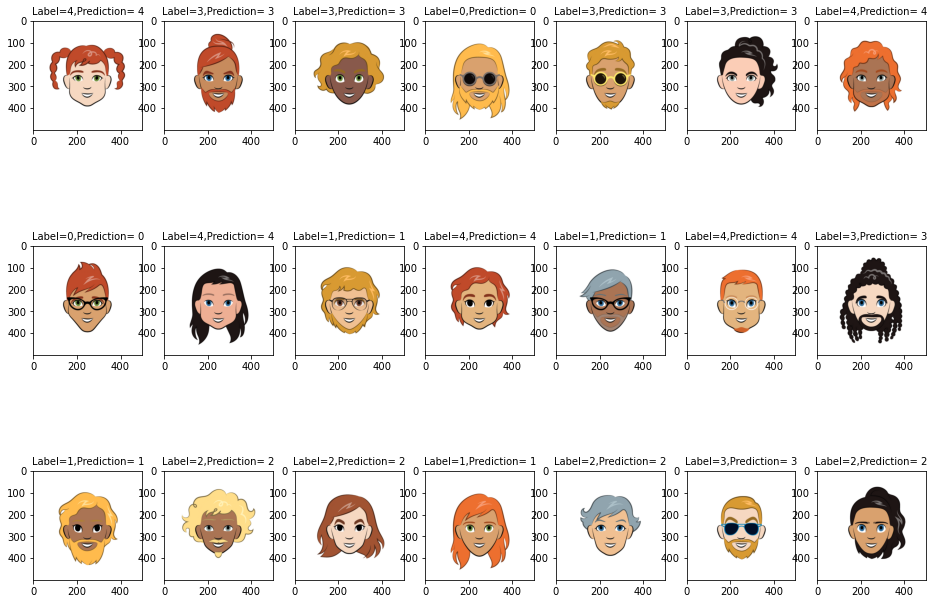

In [29]:
plot_images_true_predicted_faceShape(y_test,y_pred,images_folder)